# ДЗ 2:

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt (5 баллов)

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)


В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped
(+ 5 балла за обьяснения и выводы)


3. Реализовать разбивку на бакеты любым (правильным) способом, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)


4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)
подсчитать результаты для случая без постстратификации и с постстратификацией. (дисперсию и среднее)
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)


(+ 5 балла за обьяснения и выводы)

In [1]:
import os
import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import hashlib
from base64 import b64encode
from math import inf

import warnings
warnings.filterwarnings("ignore")

## [1] 🚀
1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:  
- метрике cart_added_cnt (5 баллов)

In [2]:
shop_metrics_new = pd.read_csv('./data_hw2/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('./data_hw2/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('./data_hw2/shop_df_users.csv').drop(columns='Unnamed: 0')
shop_df_info = pd.read_csv('./data_hw2/df_hw.csv').drop(columns='Unnamed: 0')

### Utils

In [3]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()

    return df

def salt_generator(salt=None):
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')

def groups_splitter(df, user_salt=None):
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))
    return df[['user_id', 'group']].drop_duplicates()

def compute_power_correctness(df, metric, test_fn, effect=0.05, n=100):
    correctness = []
    power = []    
    shop = df.drop(columns=['group'])
    
    for i in tqdm(range(n)):
        new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
        new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
        
        vec_a = new_df[(new_df['group'] == 'A')][metric]
        vec_b = new_df[(new_df['group'] == 'B')][metric]
        vec_b_effect = vec_b * (1 + effect)
        p_cor, p_power = test_fn(vec_a, vec_b)[1], test_fn(vec_a, vec_b_effect)[1]
        correctness.append(p_cor)
        power.append(p_power)
        
    correctness = np.array(correctness)
    
    sns.set(rc={'figure.figsize':(4.7,4.27)})
    sns.histplot(data=correctness, bins=10, color='brown', kde=True)
    
    correctness_value = (1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0]))
    power = np.array(power)
    power_value = (power[power < 0.05].shape[0] / power.shape[0])
    
    print(f'Корректность: {correctness_value * 100}%\nPOWER: {power_value * 100}%')

In [4]:
# Метрика cart_added_cnt (5 баллов)

ranked = rank_transformation(
    shop_metrics_new[shop_metrics_new.group == 'A'],
    shop_metrics_new[shop_metrics_new.group == 'B'], 'cart_added_cnt'
)

  0%|          | 0/100 [00:00<?, ?it/s]

Корректность: 93.0%
POWER: 100.0%


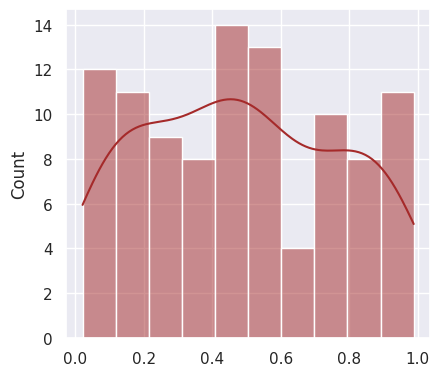

In [5]:
compute_power_correctness(ranked, 'rank', stats.ttest_ind)

  0%|          | 0/100 [00:00<?, ?it/s]

Корректность: 97.0%
POWER: 100.0%


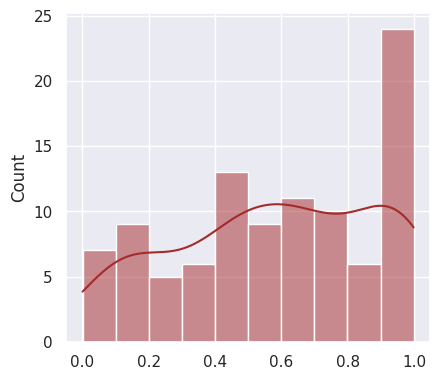

In [6]:
compute_power_correctness(shop_metrics_new, 'cart_added_cnt', stats.mannwhitneyu)

На обоих тестах мы получили хорошие результаты, но ранговая трансформация показала результаты чуть по хуже

In [7]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

TtestResult(statistic=-1.2743727811526857, pvalue=0.20253266477504916, df=222519.0)

In [8]:
stats.mannwhitneyu(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'],
                   shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

MannwhitneyuResult(statistic=6179368188.5, pvalue=0.2025319893087626)

### 🫠
Выходит, что статичтически значимых различий в метрике cart_added_cnt между группами нет (p_value > 0.05).   
В целом, результаты двух метрик получились похожими, так как оба метода работают с ранговыми данными.    

**Вывод:** t-тест с ранговой трансформация показывает меньшую корректность, чем тест Манна-Уитни, но в целом оба результата хороши.

## [2] 🧑‍🔧

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)

### Utils

In [9]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()


def get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, metric):
    shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', metric]], on=['user_id'], how='left')
    shop_metrics_all = shop_metrics_all\
                   .rename(columns={f'{metric}_x': f'{metric}', f'{metric}_y': f'{metric}_covariate'})
    shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), [metric])
    return shop_metrics_all_cuped

def get_vecs(df, metric, effect=0.05, ranked=False, log=False):
    vec_a = df[(df['group'] == 'A')][metric]
    vec_b = df[(df['group'] == 'B')][metric]
    if log:
        vec_b_effect = vec_b + np.log(1 + effect)
    else:
        vec_b_effect = vec_b * (1 + effect)
    if ranked:
        df_b = df[df.group == 'B'].drop(columns=[metric])
        df_b[metric] = list(vec_b_effect)
        ranked_df_effect = rank_transformation(df[df.group == 'A'], df_b, metric)
        vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
        vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']
        return vec_a_power, vec_b_power
    return vec_a, vec_b_effect
    

def compare_power_cuped(shop_metrics_new, shop_metrics_old, metric, effect=0.05, n=100, ranked=False, log=False):
    shop = shop_metrics_new.drop(columns=['group'])
    power = []
    power_cuped = []
    
    for i in tqdm(range(n)):
        new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
        new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
        all_df = pd.merge(new_df, shop_metrics_old[['user_id', metric]], on=['user_id'], how='left')
        all_df = all_df.rename(columns={f'{metric}_x': metric, f'{metric}_y': f'{metric}_covariate'})
        cuped_df = cuped_transform(all_df, [metric])
    
        vec_a_power, vec_b_power = get_vecs(all_df, metric, effect=effect, ranked=ranked)
        vec_a_cuped_power, vec_b_cuped_power = get_vecs(cuped_df, f'{metric}_cuped', effect=effect, ranked=ranked)
        
        p_power, p_power_cuped = stats.ttest_ind(vec_a_power, vec_b_power)[1], stats.ttest_ind(vec_a_cuped_power, vec_b_cuped_power)[1]
        power.append(p_power)
        power_cuped.append(p_power_cuped)
    
    power = np.array(power)
    power_cuped = np.array(power_cuped)

    power_value = (power[power < 0.05].shape[0] / power.shape[0])
    power_cuped_value = (power_cuped[power_cuped < 0.05].shape[0] / power_cuped.shape[0])
    
    print(f'POWER:\nбез cuped: {power_value * 100}%\tcuped: {power_cuped_value * 100}% ')
    return power_value, power_cuped_value

In [10]:
shop_metrics_all_cuped = get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, 'cart_added_cnt')

In [11]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped'])

TtestResult(statistic=-1.3855896128447498, pvalue=0.16587364048767594, df=222519.0)

In [12]:
compare_power_cuped(shop_metrics_new, shop_metrics_old, 'cart_added_cnt', effect=0.05, n=100)

  0%|          | 0/100 [00:00<?, ?it/s]

POWER:
без cuped: 75.0%	cuped: 100.0% 


(0.75, 1.0)

### 🤓

Использование CUPED позволило уменьшить дисперсию метрики cart_added_cnt и, как следствие, значительно повысить мощность критерия. Мощность теста увеличилась с 75% до 100%, что означает максимальную вероятность обнаружения реального эффекта.

In [13]:
# логарфимированная метрика cart_added_cnt (5 баллов)
shop_metrics_new['cart_added_cnt_ln'] = shop_metrics_new['cart_added_cnt'].apply(lambda x: np.log(x+1))
shop_metrics_old['cart_added_cnt_ln'] = shop_metrics_old['cart_added_cnt'].apply(lambda x: np.log(x+1))

In [14]:
shop_metrics_all_cuped_ln = get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, 'cart_added_cnt_ln')

In [15]:
stats.ttest_ind(shop_metrics_all_cuped_ln[shop_metrics_all_cuped_ln.group == 'A']['cart_added_cnt_ln_cuped'],
                shop_metrics_all_cuped_ln[shop_metrics_all_cuped_ln.group == 'B']['cart_added_cnt_ln_cuped'])

TtestResult(statistic=-2.0493551017035605, pvalue=0.04042857406821207, df=222519.0)

In [16]:
compare_power_cuped(shop_metrics_new, shop_metrics_old, 'cart_added_cnt_ln', effect=0.05, n=100, log=True)

  0%|          | 0/100 [00:00<?, ?it/s]

POWER:
без cuped: 96.0%	cuped: 100.0% 


(0.96, 1.0)

### 😎😎😎

Ранговая метрика изначально показала высокую мощность (~96%) благодаря устойчивости к выбросам. Применение CUPED дало дополнительный прирост мощности (в данном эксперименте — до ~100%).

**Вывод**: основная практическая выгода CUPED проявляется при работе с неранжированными, нелогарифмированными метриками.

## [3] 😶‍🌫️

3. Реализовать разбивку на бакеты любым (правильным) способом, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)

In [17]:
shop_metrics_new['lognorm'] = np.random.lognormal(size=len(shop_metrics_new))

In [18]:
shop_metrics_new['lognorm_bucket'] = shop_metrics_new['lognorm'].apply(lambda x: x//10)
shop_metrics_new['lognorm_bucket'].unique()

array([ 0.,  1.,  3.,  2.,  5.,  4., 19.,  6.,  8.])

In [19]:
f"Дисперсия уменьшилась с {shop_metrics_new['lognorm'].std():.2f} до {shop_metrics_new['lognorm_bucket'].std():.2f}"

'Дисперсия уменьшилась с 2.22 до 0.14'

In [63]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['lognorm'], shop_metrics_new[shop_metrics_new.group == 'B']['lognorm'])

TtestResult(statistic=2.079961880189424, pvalue=0.03753017115833517, df=222519.0)

In [54]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['lognorm_bucket'], shop_metrics_new[shop_metrics_new.group == 'B']['lognorm_bucket'])

TtestResult(statistic=-0.42883166848605253, pvalue=0.6680461457641562, df=222519.0)


Без применения бакетирования t-тест показал наличие статистически значимых различий между группами.
После применения бакетирования t-тест, напротив, не выявил статистически значимых различий: при этом значение *p-value* увеличилось с 0.04 до 0.67.

In [22]:
shop_metrics_old['lognorm'] = np.random.lognormal(size=len(shop_metrics_old))
shop_metrics_old['lognorm_bucket'] = shop_metrics_old['lognorm'].apply(lambda x: x//10)

In [23]:
shop_metrics_all_lognorm_cuped = get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, 'lognorm')
shop_metrics_all_lognorm_bucket_cuped = get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, 'lognorm_bucket')

In [24]:
# Проверим равенство средних в группах
shop_metrics_all_lognorm_cuped.groupby('group')['lognorm_covariate'].mean()

group
A    1.651789
B    1.640535
Name: lognorm_covariate, dtype: float64

In [25]:
shop_metrics_all_lognorm_bucket_cuped.groupby('group')['lognorm_bucket_covariate'].mean()

group
A    0.012720
B    0.012356
Name: lognorm_bucket_covariate, dtype: float64

Средние в группах в ковариате равны с точностью до десятитысячных и для обычной метрики, и для бакетированной.  
При этом необходимо проверить, cовпадают ли средние в метрике до и после применения cuped?

In [26]:
shop_metrics_new['lognorm'].mean() == shop_metrics_all_lognorm_cuped['lognorm'].mean()

True

In [27]:
shop_metrics_new['lognorm_bucket'].mean() == shop_metrics_all_lognorm_cuped['lognorm_bucket'].mean()

True

Средние в метрике до и после применения cuped совпадают и для обычной метрики, и для бакетированной.

In [62]:
stats.ttest_ind(shop_metrics_all_lognorm_cuped[shop_metrics_all_lognorm_cuped.group == 'A']['lognorm_cuped'],
                shop_metrics_all_lognorm_cuped[shop_metrics_all_lognorm_cuped.group == 'B']['lognorm_cuped'])

TtestResult(statistic=2.077712285767691, pvalue=0.03773701061259118, df=222519.0)

In [58]:
stats.ttest_ind(shop_metrics_all_lognorm_bucket_cuped[shop_metrics_all_lognorm_bucket_cuped.group == 'A']['lognorm_bucket_cuped'],
                shop_metrics_all_lognorm_bucket_cuped[shop_metrics_all_lognorm_bucket_cuped.group == 'B']['lognorm_bucket_cuped'])

TtestResult(statistic=-0.43028813685962236, pvalue=0.6669864723046366, df=222519.0)


Применение CUPED значительно не изменило p-value как для обычной, так и для бакетированной метрики.

In [30]:
# На метрике cart_added_cnt (5 баллов)
shop_metrics_new['cart_added_cnt'].unique()

array([ 0,  2,  1,  3, 12,  4,  6,  5,  8,  7, 56, 38, 15, 17,  9, 23, 11,
       10, 13, 75, 21, 19, 20, 28, 22, 14, 39, 51, 24, 33, 16, 18, 41, 25,
       61])

In [31]:
shop_metrics_new['cart_added_cnt_bucket'] = shop_metrics_new['cart_added_cnt'].apply(lambda x: x//10)
shop_metrics_new['cart_added_cnt_bucket'].unique()

array([0, 1, 5, 3, 2, 7, 4, 6])

In [32]:
f"Дисперсия уменьшилась с {shop_metrics_new['cart_added_cnt'].std():.2f} до {shop_metrics_new['cart_added_cnt_bucket'].std():.2f}"

'Дисперсия уменьшилась с 0.63 до 0.04'

In [64]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'], shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

TtestResult(statistic=-1.3047727178459143, pvalue=0.19197160099583152, df=222519.0)

In [65]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt_bucket'], shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt_bucket'])

TtestResult(statistic=-0.46024411491481815, pvalue=0.6453414591158615, df=222519.0)

И с бакетированием, и без него тест не показал значимых различий между группами, но после бакетирования p-value значительно увеличилось (с 0.19 до 0.65).   
Вероятно, бакетирование сильно "размыло" различие между группами: пропало различие между теми, кто положил в корзину 9 товаров и 0 товаров.

In [35]:
shop_metrics_old['cart_added_cnt_bucket'] = shop_metrics_old['cart_added_cnt'].apply(lambda x: x//10)
shop_metrics_all_cuped = get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, 'cart_added_cnt')
shop_metrics_all_bucket_cuped = get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, 'cart_added_cnt_bucket')

In [36]:
# Проверим равность средних в группах
shop_metrics_all_cuped.groupby('group')['cart_added_cnt_covariate'].mean()

group
A    0.140557
B    0.143426
Name: cart_added_cnt_covariate, dtype: float64

In [37]:
shop_metrics_all_bucket_cuped.groupby('group')['cart_added_cnt_bucket_covariate'].mean()

group
A    0.000674
B    0.000764
Name: cart_added_cnt_bucket_covariate, dtype: float64

Средние в группах в ковариате равны с точностью до сотых для обычной метрики и с точностью до тысячных для бакетированной метрики.

Проверим насколько совпадают средние в метрике до и после применения cuped.

In [38]:
shop_metrics_new['cart_added_cnt'].mean() == shop_metrics_all_cuped['cart_added_cnt'].mean()

True

In [39]:
shop_metrics_new['cart_added_cnt_bucket'].mean() == shop_metrics_all_bucket_cuped['cart_added_cnt_bucket'].mean()

True

Средние в метрике до и после применения cuped совпадают и для обычной метрики, и для бакетированной.

In [40]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped'])

TtestResult(statistic=-1.3855896128447498, pvalue=0.16587364048767594, df=222519.0)

In [41]:
stats.ttest_ind(shop_metrics_all_bucket_cuped[shop_metrics_all_bucket_cuped.group == 'A']['cart_added_cnt_bucket_cuped'],
                shop_metrics_all_bucket_cuped[shop_metrics_all_bucket_cuped.group == 'B']['cart_added_cnt_bucket_cuped'])

TtestResult(statistic=0.22875639879434695, pvalue=0.8190584671361201, df=222519.0)

Для обычной метрики применение CUPED уменьшило p-value (0.19 -> 0.16), а для бакетированной, наоборот, увеличило (0.65 -> 0.82).

**Выводы:** 
- Для логнормальных данных бакетирование помогает стабилизировать дисперсию и убрать выбросы. В случае же метрик с низкой дисперсией (например, целочисленных) важно не делать интервалы слишком большими, чтобы сохранить контраст между разными группами.

- Бакетирование полезно для логнормальных метрик — оно снижает дисперсию и убирает выбросы. Но для метрик с малой дисперсией (как cart_added_cnt) крупные интервалы группировки могут скрыть различия между группами, поэтому их лучше не использовать.

## [4] 🤗  
4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов) подсчитать результаты для случая без постстратификации и с постстратификацией. (дисперсию и среднее)
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)

In [42]:
shop_users_info

,user_id,user_age,user_sex
0,1515915625519388267,41,f
1,1515915625519380411,84,m
2,1515915625513238515,41,m
3,1515915625519014356,25,m
4,1515915625510743344,42,m
...,...,...,...
407278,1515915625611023671,76,m
407279,1515915625611023730,34,m
407280,1515915625611024014,62,m
407281,1515915625611024020,48,f


### Utils 

In [43]:
def get_strf_group(x, sex=True, age=True):
    assert sex or age, 'Stratification should be by sex or/and age'
    group = x['user_sex'] if sex else ''
    if age:
        age_groups = [(18, 24), (25, 45), (46, 60), (61, 75), (76, inf)]
        for minlim, maxlim in age_groups:
            if minlim <= x['user_age'] <= maxlim:
                group += f'_{minlim}-{maxlim}'
    return group

def poststratify(df, sex=True, age=True):
    shop_w_features = pd.merge(df, shop_users_info, on=['user_id'], how='left')
    shop_w_features['strf'] = shop_w_features.apply(lambda x: get_strf_group(x, sex=sex, age=age), axis=1)
    return shop_w_features

In [44]:
shop_w_features = poststratify(shop_metrics_old)
shop_w_features.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_ln,lognorm,lognorm_bucket,cart_added_cnt_bucket,user_age,user_sex,strf
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0,0.0,0.725161,0.0,0,55,f,f_46-60
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0,0.0,0.410674,0.0,0,58,m,m_46-60
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0,0.0,1.321205,0.0,0,23,f,f_18-24
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0,0.0,0.474447,0.0,0,33,m,m_25-45
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0,0.0,0.281129,0.0,0,26,f,f_25-45


In [45]:
stats.ttest_ind(shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'],
                shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'])

TtestResult(statistic=-0.7331870372707812, pvalue=0.4634447828246868, df=406861.0)

In [46]:
def test_poststratified(shop_w_features, metric, feature='strf', verbose=True):
    N = shop_w_features['user_id'].nunique()
    
    strats_weights = {}
    
    mean_a, mean_b, std_a, std_b = 0, 0, 0, 0
    
    for i in range(0, shop_w_features[feature].nunique()):
        key = shop_w_features[feature].value_counts().index[i]
        strats_weights[key] = shop_w_features[feature].value_counts()[i] / N
        mean_a += shop_w_features[(shop_w_features.group == 'A') & (shop_w_features[feature] == key)][metric].mean() * strats_weights[key]
        mean_b += shop_w_features[(shop_w_features.group == 'B') & (shop_w_features[feature] == key)][metric].mean() * strats_weights[key]
        std_a += shop_w_features[(shop_w_features.group == 'A') & (shop_w_features[feature] == key)][metric].std()**2 * strats_weights[key]
        std_b += shop_w_features[(shop_w_features.group == 'B') & (shop_w_features[feature] == key)][metric].std()**2 * strats_weights[key]
    
    n_a = len(shop_w_features[shop_w_features.group == 'A'])
    n_b = len(shop_w_features[shop_w_features.group == 'B'])
    
    if verbose:
        print(f'effect: {(mean_b - mean_a)/mean_a*100}, std_a: {std_a}, std_b: {std_b}')

    return stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)

In [47]:
test_poststratified(shop_w_features, 'cart_added_cnt')

effect: 1.1238909894351434, std_a: 0.33278038455229625, std_b: 0.3586264542191377


Ttest_indResult(statistic=-1.2454768228689563, pvalue=0.2129572471320501)

И с постстратификацией и без него тест не показал значимых различий между группами, но с постстратификацией p-value почти в два раза ниже. Возможно, для каких-то половозрастных групп различия между группами A и B более выражены. Проверим это.

In [48]:
for key in sorted(shop_w_features['strf'].unique()):
    print(key)
    print(stats.ttest_ind(shop_w_features[shop_w_features['strf'] == key][shop_w_features.group == 'A']['cart_added_cnt'],
                shop_w_features[shop_w_features['strf'] == key][shop_w_features.group == 'B']['cart_added_cnt']))

f_18-24
TtestResult(statistic=-1.266858540599369, pvalue=0.20522328237478235, df=16950.0)
f_25-45
TtestResult(statistic=-0.39299361960582735, pvalue=0.6943258372048688, df=50977.0)
f_46-60
TtestResult(statistic=-1.3735823653700876, pvalue=0.1695798236274159, df=36445.0)
f_61-75
TtestResult(statistic=0.9180034589371632, pvalue=0.3586231740161858, df=36183.0)
f_76-inf
TtestResult(statistic=-2.0457070205331305, pvalue=0.040796961236604166, df=22205.0)
m_18-24
TtestResult(statistic=0.4675950776514708, pvalue=0.6400781497721612, df=25704.0)
m_25-45
TtestResult(statistic=0.5809968635854353, pvalue=0.5612442696570454, df=76920.0)
m_46-60
TtestResult(statistic=-0.6842568711378716, pvalue=0.4938158800493182, df=54602.0)
m_61-75
TtestResult(statistic=0.11940596450181902, pvalue=0.9049541782696899, df=54248.0)
m_76-inf
TtestResult(statistic=0.48092299846201075, pvalue=0.6305744531876034, df=32609.0)


In [49]:
shop_users_info.groupby('user_sex').count()[['user_id']].reset_index()

,user_sex,user_id
0,f,162918
1,m,244365


Действительно, для женщин p-value в среднем ниже, чем для мужчин. Причем для женщин 76+ различия статистически значимы. При этом мужчин в выборке намного больше, засчет чего в тесте без постстратификации эффект теряется.

Проверим мощность и корректность t-критерия для постстратифицированного случая (5 баллов)

In [50]:
def compare_power_correctness_posstratified(df, metric, effect=0.05, n=100, sex=True, age=True):
    correctness = []
    power = []
    
    correctness_pststrf = []
    power_pststrf = []
    
    shop = df.drop(columns=['group'])
    
    for i in tqdm(range(n)):
    
        new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
        new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
        shop_w_features = poststratify(new_df, sex=sex, age=age)
        
        vec_a = new_df[(new_df['group'] == 'A')][metric]
        vec_b = new_df[(new_df['group'] == 'B')][metric]
        vec_b_effect = vec_b * (1 + effect)
        p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
        correctness.append(p_cor)
        power.append(p_power)
    
    
        shop_w_features_w_effect = shop_w_features.copy()
        shop_w_features_w_effect[metric] = shop_w_features_w_effect.apply(lambda x: x[metric]*(1 + effect) if x.group == 'B' else x[metric], axis=1)
        
        p_cor_pststrf, p_power_pststrf = test_poststratified(shop_w_features, metric, verbose=False)[1], test_poststratified(shop_w_features_w_effect, metric, verbose=False)[1]
        correctness_pststrf.append(p_cor_pststrf)
        power_pststrf.append(p_power_pststrf)
        
    
    correctness = np.array(correctness)
    correctness_pststrf = np.array(correctness_pststrf)
    
    sns.set(rc={'figure.figsize':(4.7,4.27)})
    sns.histplot(data=correctness, bins=10, color='brown', kde=True)
    sns.histplot(data=correctness_pststrf, bins=10, color='blue', kde=True)
    
    correctness_value = (1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0]))
    correctness_pststrf_value = (1 - (correctness_pststrf[correctness_pststrf < 0.05].shape[0] / correctness_pststrf.shape[0]))
    
    
    power = np.array(power)
    power_pststrf = np.array(power_pststrf)
    
    power_value = (power[power < 0.05].shape[0] / power.shape[0])
    power_pststrf_value = (power_pststrf[power_pststrf < 0.05].shape[0] / power_pststrf.shape[0])

    
    print(f'Постстратификация (по полу={sex}\tпо возрасту={age})')
    print()
    print(f'CORRECTNESS:\nбез постстратификации: {correctness_value * 100}%\tс постстратификацией: {correctness_pststrf_value * 100}% ')
    print()
    print(f'POWER:\nбез постстратификации: {power_value * 100}%\tс постстратификацией: {power_pststrf_value * 100}% ')

  0%|          | 0/100 [00:00<?, ?it/s]

Постстратификация (по полу=True	по возрасту=True)

CORRECTNESS:
без постстратификации: 92.0%	с постстратификацией: 74.0% 

POWER:
без постстратификации: 87.0%	с постстратификацией: 95.0% 


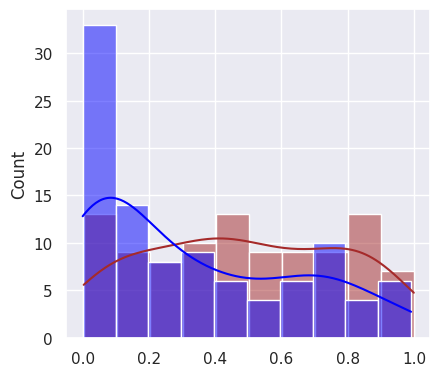

In [51]:
compare_power_correctness_posstratified(shop_metrics_old, 'cart_added_cnt', n=100)

## 🤔🎃💜🧠

Корректность упала с 92% до 74% — это может свидетельствовать о росте частоты ложных срабатываний после постстратификации. Вероятно, постстратификация внесла смещение или не учла групповые различия в достаточной мере, из-за чего тест стал хуже распознавать отсутствие эффекта.

В то же время мощность выросла с 87% до 95%, что указывает на повышенную способность фиксировать реальные различия между группами после поправки на пол и возраст.

**Итог:** Постстратификация полезна, если пол и возраст существенно влияют на измеряемую метрику; при их незначительном влиянии она может добавить лишний шум и уменьшить корректность.

---

__Воспользуюсь случаем и поздравлю Вас с наступающим Новым годом!__
# 🤶 🎅 🎄 
_There are 18 days left until New Year!_